# NSMC task using Huggingface Transformers

__할 일__
  - 레이어 프리징


__한 일__
  - test 용 dataset shard 만들기 (배치사이즈 8일떄 1에포크 약 2분)
  - Drop raw text column from input (GPU메모리에 영향 없음)
  - 체크포인트 저장 (자동저장 된 체크포인트들 로딩 문제 없음)
  - bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습
  - 가장 긴 토큰 길이 구하기; max_length 세팅
  - train-eval split


__결과__
  - 의도인지는 모르지만 huggingface의 기본 모듈 구현이 파이토치 베이스여서 LMS 예제도 파이토치를 썼다.
  - bucketing과 dynamic padding이 생각보다 연산 효율이 좋은 것 같다.
  - 메모리 효율도 상당한 것 같고. (배치 사이즈 4배까지 가능했음.)
  - 더 나은 성능을 위해 우선 정확도 0.9 에서 맞추지 못한 샘플이 뭔지 꺼내볼 필요가 있는 것 같다.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from transformers import Trainer, TrainingArguments

import datasets
from datasets import load_dataset

In [2]:
huggingface_nsmc_dataset = load_dataset('nsmc')
print(huggingface_nsmc_dataset)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


### 모델 로드 - baseline

In [3]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained(
                                        'klue/bert-base', num_labels = 2 )

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [4]:
huggingface_model.config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [9]:
# from torchinfo import summary; torchinfo 패키지가 없는 것 같다...
# summary(huggingface_model) #, input_size=(2, 512), dtypes=['torch.IntTensor'])

for layer_name, params in huggingface_model.named_parameters():
    print(layer_name,'---', params.shape)

bert.embeddings.word_embeddings.weight --- torch.Size([32000, 768])
bert.embeddings.position_embeddings.weight --- torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight --- torch.Size([2, 768])
bert.embeddings.LayerNorm.weight --- torch.Size([768])
bert.embeddings.LayerNorm.bias --- torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight --- torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias --- torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight --- torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias --- torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight --- torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias --- torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight --- torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias --- torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight --- torch.Size([768])
bert.encoder.layer.0.attent

In [21]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        # data['sentence2'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        max_length = 256
        )

In [22]:
hf_dataset = huggingface_nsmc_dataset.map(transform, batched=True, num_proc=3)

In [23]:
print(huggingface_nsmc_dataset.column_names, '\n', 
      hf_dataset['train'], hf_dataset['test'])

{'train': ['id', 'document', 'label'], 'test': ['id', 'document', 'label']} 
 Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 150000
}) Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 50000
})


In [24]:
# train & validation & test split
hf_train_dataset = hf_dataset['train']
# hf_val_dataset = hf_dataset['validation']
hf_test_dataset = hf_dataset['test']

len(hf_train_dataset)

150000

In [25]:
# 훈련 테스트용 데이터셋 1/100 샤드 -- 배치사이즈 8일떄 1에포크 약 2분 
hf_dataset_xmpl = hf_train_dataset.shard(num_shards=100, index=0)
hf_dataset_xmpl_test = hf_test_dataset.shard(100, 1)

len(hf_dataset_xmpl), len(hf_dataset_xmpl_test)

(1500, 500)

In [26]:
print(len(hf_dataset_xmpl['input_ids'][0]))
# 모델입력에 들어가지 않는 column 지우기
hf_dataset_xmpl = hf_dataset_xmpl.remove_columns(['document', 'id'])

256


In [27]:
from datasets import load_metric
metric = load_metric('glue', 'sst2')

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [28]:
def compute_metrics(eval_pred):    
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

#### 모델 훈련 작동 테스트

In [ ]:
output_dir = os.getenv('HOME')+'/aiffel/huggingface/checkpoints'

training_arguments = TrainingArguments(
    output_dir,                               # output이 저장될 경로
    do_eval = False,
    # evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    # per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

# del huggingface_model
# huggingface_model = AutoModelForSequenceClassification.from_pretrained(
#                                            'klue/bert-base', num_labels = 2 )

trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_dataset_xmpl,    # training dataset
    # eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(hf_dataset_xmpl_test)

#### 모델 훈련 - baseline

In [ ]:
training_arguments = TrainingArguments(
    output_dir,                               # output이 저장될 경로
    # do_eval = False,
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 2,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [ ]:
# del huggingface_model
# huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

tiny_hf_test_dataset = hf_test_dataset.shuffle(seed=42).shard(50, 1)

trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=tiny_hf_test_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
trainer.save_checkpoint("/aiffel/aiffel/huggingface/checkpoints/checkpoint_01.ckpt")

In [ ]:
# trainer.evaluate(hf_test_dataset)
# https://huggingface.co/datasets/nyu-mll/glue/discussions/15

#### 저장된 모델 로드 및 시각화  - baseline

In [ ]:
# 2, 3번째 에포크 훈련 체크포인트 자동저장 경로
from os.path import join, getsize
ckpt_path_list = []
for root, dirs, files in os.walk(output_dir): # '~/aiffel/huggingface/checkpoints'
    for name in set(dirs):
        if name.startswith('checkpoint-'):
            ckpt_path_list.append(join(root, name))

print("ckpt_path_list: ", len(ckpt_path_list))

In [ ]:
# '-' 뒤 붙은 스텝 수로 정렬
ckpt_path_list.sort(key=lambda x: int(x.split('-')[1]))

In [ ]:
print(*(p+'\n' for p in ckpt_path_list[:10]))

In [ ]:
# 모델 불러오기 및 evaluate 결과 취합
eval_result_list = []
for ckpt_path in ckpt_path_list:
    
    huggingface_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    
    trainer = Trainer(
        model=huggingface_model,           # 학습시킬 model
        args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
        train_dataset=hf_train_dataset,    # training dataset
        eval_dataset=tiny_hf_test_dataset,       # evaluation dataset
        compute_metrics=compute_metrics,
    )

    eval_result = trainer.evaluate(tiny_hf_test_dataset)
    eval_result_list.append(eval_result)

In [ ]:
# 1번째 에포크 훈련 체크포인트 자동저장 결과 취합
ckpt_path_list = []
output_dir_2 = os.getenv('HOME')+"/aiffel/huggingface_ckpt"
for root, dirs, files in os.walk(output_dir_2):
    for name in set(dirs):
        if name.startswith('checkpoint-'):
            ckpt_path_list.append(join(root, name))

ckpt_path_list.sort(key=lambda x: int(x.split('-')[1]))
print("ckpt_path_list: ", len(ckpt_path_list))
eval_result_list_0 = []
for ckpt_path in ckpt_path_list:
    
    huggingface_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
    
    trainer = Trainer(
        model=huggingface_model,           # 학습시킬 model
        args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
        train_dataset=hf_train_dataset,    # training dataset
        eval_dataset=tiny_hf_test_dataset,       # evaluation dataset
        compute_metrics=compute_metrics,
    )

    eval_result = trainer.evaluate(tiny_hf_test_dataset)
    eval_result_list_0.append(eval_result)

In [ ]:
tot_eval_list = eval_result_list_0 + eval_result_list
print(tot_eval_list[0])

In [ ]:
# training result
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1); key = 'eval_loss'
plt.plot([e[key] for e in tot_eval_list], 'b-', label=key)
plt.xlabel('500 steps')
plt.legend()

plt.subplot(1, 3, 2); key = 'eval_accuracy'
plt.plot([e[key] for e in tot_eval_list], 'r-', label=key)
plt.xlabel('500 steps')
plt.legend()

plt.subplot(1, 3, 3); key = 'eval_runtime'
plt.plot([e[key] for e in tot_eval_list], 'g-', label=key)
plt.xlabel('500 steps')
plt.legend()


plt.show()

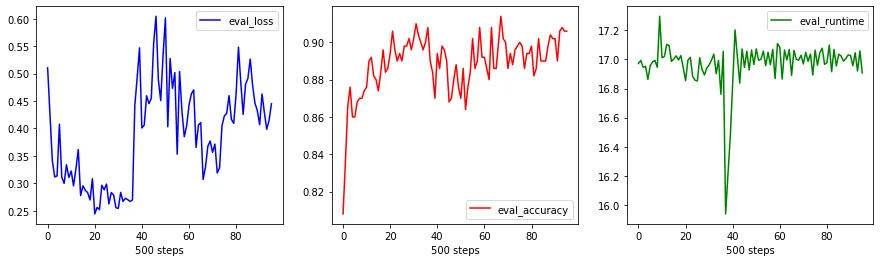

### Bucketing, Dynamic Padding

In [30]:
def tknz_no_pad(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = False,
        padding = False,
        return_token_type_ids = False,
        )

def get_seq_len(data):
    return len(data)

In [51]:
hf_dataset_no_pad = huggingface_nsmc_dataset.map(tknz_no_pad, batched=True, num_proc=3)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-9eef7de866b96eac.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-4e21f5dbd29dad59.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-7a7d4807fd87ad2c.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-e80cb2a183331a82.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-c1eebbbf4ea31f64.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsm

In [52]:
hf_train_no_pad = hf_dataset_no_pad['train']
hf_test_no_pad = hf_dataset_no_pad['test']

len(hf_train_dataset)

150000

In [33]:
hf_train_no_pad_xmpl = hf_train_no_pad.shard(num_shards=100, index=0)
hf_test_no_pad_xmpl = hf_test_no_pad.shard(num_shards=100, index=0)

len(hf_train_no_pad_xmpl)

1500

In [53]:
hf_split_no_pad = hf_train_no_pad.train_test_split(test_size=0.1)

In [54]:
hf_train_no_pad = hf_split_no_pad['train']
hf_eval_no_pad = hf_split_no_pad['test']

In [ ]:
# 입력 시퀀스 최대 길이 구하기
max(len(i['input_ids']) for i in hf_train_no_pad), \
max(len(i['input_ids']) for i in hf_test_no_pad)

In [36]:
from transformers import DataCollatorWithPadding
nsmc_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer)

#### 모델 구성 - dropout 추가된 config

In [56]:
from transformers import AutoConfig
klue_bert_config = AutoConfig.from_pretrained('klue/bert-base', classifier_dropout = 0.3, num_labels=2)  

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [57]:
huggingface_model = AutoModelForSequenceClassification.from_pretrained(
                        'klue/bert-base', config=klue_bert_config)

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transformers/05b36ee62545d769939a7746eca739b844a40a7a7553700f110b58b28ed6a949.7cb231256a5dbe886e12b902d05cb1241f330d8c19428508f91b2b28c1cfe0b6
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

#### 모델 훈련 작동 테스트 - Bucketing, Dynamic Padding, dropout 추가

In [38]:
# 훈련 테스트 런
output_dir = os.getenv('HOME')+'/aiffel/huggingface/checkpoints'

training_arguments = TrainingArguments(
    output_dir,                               # output이 저장될 경로
    # do_eval = False,
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_no_pad_xmpl,    # training dataset
    eval_dataset=hf_test_no_pad_xmpl,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=nsmc_collator,          ### dynamic padding 적용
#     tokenizer=huggingface_tokenizer,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 1500
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.450279,0.800000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=47, training_loss=0.5570618243927651, metrics={'train_runtime': 18.8021, 'train_samples_per_second': 79.778, 'train_steps_per_second': 2.5, 'total_flos': 54646932865200.0, 'train_loss': 0.5570618243927651, 'epoch': 1.0})

#### 모델 훈련 - Bucketing, Dynamic Padding, dropout 추가

In [58]:
log_dir = os.getenv('HOME')+'/aiffel/huggingface/logs'

training_arguments = TrainingArguments(
    output_dir,                               # output이 저장될 경로
    # do_eval = False,
    evaluation_strategy = 'steps', #"epoch",      #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 6,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    group_by_length = True,                       ### Bucketing을 적용
    eval_steps = 500,
    save_steps = 500,
    # save_only_model  = True,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
#     logging_dir = log_dir,
#     logging_steps = 10,

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [59]:
tiny_hf_test_dataset = hf_test_dataset.shuffle(seed=42).shard(50, 1)

trainer = Trainer(
    model = huggingface_model,           # 학습시킬 model
    args = training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset = hf_train_no_pad,    # training dataset
    eval_dataset = hf_eval_no_pad,       # evaluation dataset
    compute_metrics = compute_metrics,
    data_collator = nsmc_collator,          ### dynamic padding 적용
)
trainer.train()

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-8d82332cbe95855a.arrow
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 135000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 25314


Step,Training Loss,Validation Loss,Accuracy
500,0.360400,0.297157,0.875933
1000,0.296200,0.272167,0.886933
1500,0.292700,0.279466,0.882467
2000,0.286800,0.255266,0.893867
2500,0.265300,0.325775,0.876067
3000,0.266300,0.248086,0.899000
3500,0.258500,0.259056,0.894667
4000,0.254600,0.234062,0.904667
4500,0.215500,0.263421,0.903800
5000,0.185400,0.256369,0.904267


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-500
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-1000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-1000/pytorch_model.bin
T

  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-8500
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-8500/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-8500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-9000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-9000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-9000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation ****

Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-16500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-17000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-17000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-17000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-17500
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-17500/conf

***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints/checkpoint-25000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-25000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints/checkpoint-25000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /aiffel/aiffel/huggingface/checkpoints/checkpoint-12500 (score: 0.907).


TrainOutput(global_step=25314, training_loss=0.13225073086157732, metrics={'train_runtime': 7801.9596, 'train_samples_per_second': 103.82, 'train_steps_per_second': 3.245, 'total_flos': 9769070930012640.0, 'train_loss': 0.13225073086157732, 'epoch': 6.0})

In [60]:
trainer.evaluate(hf_test_no_pad)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'eval_loss': 0.30371561646461487,
 'eval_accuracy': 0.90266,
 'eval_runtime': 220.7829,
 'eval_samples_per_second': 226.467,
 'eval_steps_per_second': 7.079,
 'epoch': 6.0}

#### 모델 훈련 결과 시각화

In [23]:
raw_result = \
"""Step	Training Loss	Validation Loss	Accuracy
500	0.360400	0.297157	0.875933
1000	0.296200	0.272167	0.886933
1500	0.292700	0.279466	0.882467
2000	0.286800	0.255266	0.893867
2500	0.265300	0.325775	0.876067
3000	0.266300	0.248086	0.899000
3500	0.258500	0.259056	0.894667
4000	0.254600	0.234062	0.904667
4500	0.215500	0.263421	0.903800
5000	0.185400	0.256369	0.904267
5500	0.193600	0.260506	0.903133
6000	0.192500	0.254415	0.903867
6500	0.191000	0.253726	0.906067
7000	0.186800	0.250822	0.905867
7500	0.191500	0.249668	0.905133
8000	0.190500	0.274078	0.900600
8500	0.177900	0.289298	0.906733
9000	0.125000	0.296713	0.905800
9500	0.121900	0.303162	0.904667
10000	0.123200	0.306000	0.905800
10500	0.130600	0.296312	0.906000
11000	0.123800	0.347967	0.904667
11500	0.132800	0.286212	0.904867
12000	0.137500	0.278359	0.904733
12500	0.130800	0.297468	0.907000
13000	0.097000	0.419716	0.898600
13500	0.081900	0.400929	0.904933
14000	0.089900	0.414584	0.905000
14500	0.089200	0.367197	0.902000
15000	0.085600	0.380394	0.903800
15500	0.089500	0.399415	0.904133
16000	0.082600	0.417932	0.902400
16500	0.089000	0.414495	0.900000
17000	0.079600	0.426073	0.903133
17500	0.057400	0.465181	0.903467
18000	0.058700	0.493871	0.901000
18500	0.065000	0.484014	0.902067
19000	0.059700	0.489723	0.902733
19500	0.060200	0.488482	0.901867
20000	0.060000	0.503706	0.901733
20500	0.063600	0.481040	0.902333
21000	0.064100	0.479002	0.905067
21500	0.048000	0.512420	0.902467
22000	0.047800	0.531776	0.902533
22500	0.048500	0.529628	0.902733
23000	0.042400	0.547974	0.902800
23500	0.045300	0.546529	0.901333
24000	0.041600	0.550550	0.902400
24500	0.045900	0.551643	0.902533
25000	0.041900	0.548875	0.902600"""

In [15]:
result_lines = raw_result.split('\n')

In [18]:
heads = result_lines[0].split('\t')
train_result = {}
for ln in result_lines[1:]:
    for i, v in enumerate(ln.split('\t')):
        pts = train_result.setdefault(heads[i], [])
        pts.append(float(v))

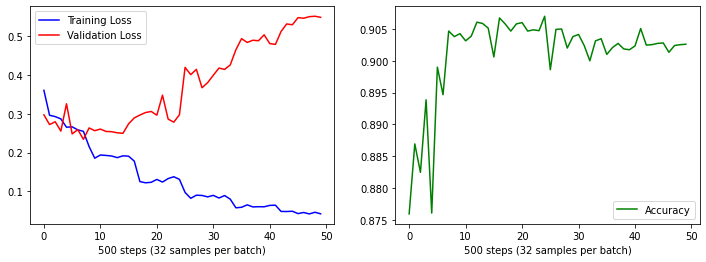

In [22]:
# training result; Training Loss, Validation Loss, Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
key = 'Training Loss'
plt.plot(train_result[key], 'b-', label=key)
key = 'Validation Loss'
plt.plot(train_result[key], 'r-', label=key)
plt.xlabel('500 steps (32 samples per batch)')
plt.legend()

plt.subplot(1, 2, 2); key = 'Accuracy'
plt.plot(train_result[key], 'g-', label=key)
plt.xlabel('500 steps (32 samples per batch)')
plt.legend()

plt.show()